# Assignment 1
## Simulation of a Cellular Telephony Network
### Problem Statement
The telecommunication company XPhone has been receiving complaints from its subscribers regarding quality of service (QoS) along a 40 km long highway connecting two major cities. The highway is covered by its cellular telephony network. The company needs to decide whether or not its system guarantees quality of service (QoS) in terms of percentages of dropped calls and blocked calls. Some measurements have been made of the traffic in the network on the highway. Our task is to model and simulate the system to determine whether the system can meet the quality of service requirements, and if so, which fixed channel allocation scheme offers the best service.

### QoS Requirements
+ blocked calls < 2%
+ dropped calls < 1%

### System Description
The two-way highway is 40 km long. The company uses 20 base stations, each covers a cell with 2 km diameter. There is no overlapping of cells. Where the reach of one base station ends, the reach of the next base station starts. Each base station has 10 channels so there are 10 channels available in each cell.
When a subscriber initiates a call from within a cell, a channel in the cell will be allocated to the call. If no free channels are available in the base station, the call is blocked. When a subscriber making a call crosses a cell boundary before the end of the 40-km highway, the channel being used in the current cell is released and a new channel in the new cell has to be acquired: this is called a **Handover**. If a channel is not available in the new base station during a handover the call is dropped. When a subscriber making a call crosses the end of the 40-km highway (either end), the call will be terminated and the channel being used is released.

A Fixed Channel Allocation (FCA) scheme is used. The company wants us to test at least two FCA schemes:
+ No channel reservation
+ 9 channels are allocated to each cell for new calls and handovers and 1 channel is reserved for handovers when the other 9 channels are not available. This means a new call will not be allocated a channel if there is only one free channel left.

**The company has provided the following measurements:**
+ Call initiation times and their first base stations
+ Call durations
+ Car speeds

**Assumptions**
+ The traffic volumes in the two directions are the same. This means the two directions of cars travelling along the highway have equal probabilities.
+ A car maintains the same speed during a call.
+ The position of the car initiating a call in a cell is uniformly distributed along the section of the highway covered by the base station.

## Outline

In the following we are going to analyse the data to find what distributions the inter-arrival times of calls, the locations where calls are generated, the call durations, and car speeds follow respectively. In addition, we also need to find the parameter values of these distributions.

After that we are going to develop a discrete-event simulator.

In the end, we are going to run our simulator multiple times, each with a warm-up period for different FCA
schemes to investigate how handover reservation scheme may affect the quality of service (i.e., blocking and dropping probabilities).

**We are going to answer the following question:**
+ Is the current system able to meet the quality of service requirements and if so how many channels should be reserved for handover for best service?

In [1]:
from heapq import *
import xlrd
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import poisson
from scipy.stats import expon

file = ("PCS_TEST_DETERMINSTIC_19S2.xls") #file of the measurements provided

## Investigate Data

### Extract Data

In [2]:
def extractData(file):
    initationTimes = []
    baseStations = []
    durations = []
    velocities = []
    
    wb = xlrd.open_workbook(file) 
    sheet = wb.sheet_by_index(0) 
    for i in range(1, sheet.nrows):
        row=sheet.row_values(i)
        initiationTime=row[1]
        baseStation=int(row[2])-1 #We use indexing from 0 instead from 1
        duration=row[3]
        speed=row[4]

        initationTimes.append(initiationTime)
        baseStations.append(baseStation)
        durations.append(duration)
        velocities.append(speed)
    
    return initationTimes, baseStations, durations, velocities

In [3]:
initationTimes, baseStations, durations, velocities = extractData(file)

### I) Call Interarrival Time Distribution

#### Step 1: Investigate Data Collection
At first we take a look at the measured interarrival times. Is the data IID?
To proof that one call does not, for example, trigger other calls we use a scatter diagramm to asses whether the data points are independent. After that we plot the data to see if it is identically distributed.

In [4]:
def getInterarrivalTimes(initationTimes):
    interarrivalTimes = []
    for i in range(1,len(initationTimes)):
        interarrivalTime = initationTimes[i]-initationTimes[i-1]
        interarrivalTimes.append(interarrivalTime)
    return interarrivalTimes

In [5]:
def createTupel(array):
    x = []
    y = []
    for i in range(1,len(array)):
        x.append(array[i-1])
        y.append(array[i])
    return x, y

In [6]:
interarrivalTimes = getInterarrivalTimes(initationTimes)
x, y = createTupel(interarrivalTimes)

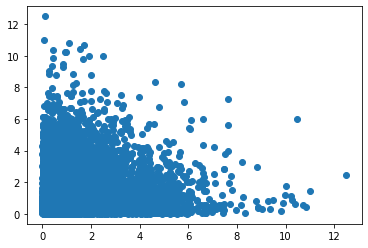

In [7]:
x, y = createTupel(interarrivalTimes)
plt.scatter(x,y)
plt.show()

The data points are scattered throughout the first quarter. This indicates that the data is independent.

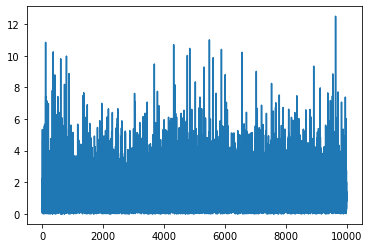

In [8]:
plt.plot(interarrivalTimes)
plt.show()

The data semes to be identical distributed as well. There are no major diffrences we can identify. We assume that the data is IID.

#### Step 2: Identify A Family Of Distributions
This step typically beginns with the development of a histogram. We break the range of data into k intervals of equal widths. Hines et al. [2002] state that k equal to the square root of the number of data items is a good approximation of k. Since we have 9999 data points we go with k = 100.

In [9]:
k=100

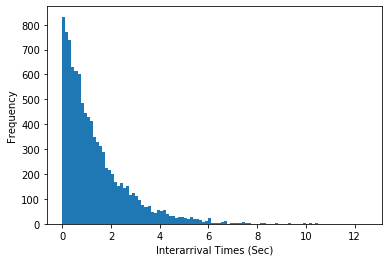

In [10]:
plt.hist(interarrivalTimes,k)
plt.xlabel('Interarrival Times (Sec)')
plt.ylabel('Frequency')
plt.show()

We hypothesize the data has an exponential distribution.

#### Step 3: Estimation of the mean for the exponential distribution

In [11]:
meanCallInterarrival = sum(interarrivalTimes)/len(interarrivalTimes)
print("Expo({})".format(meanCallInterarrival))

Expo(1.3698169264765245)


#### Step 4: Goodness-of-fit test of selected distribution

We use the chi-square test to test the hypothesis that these call interarrival times are exponentially distributed.
To calculated the end points of the intervalls, we use the percent point function (ppf) of the scipy libary.

In [12]:
def calExpInterall(mean,k):
    classIntervall = [0]
    for i in range(1,k):
        ai=expon.ppf(i/k,scale=mean)
        classIntervall.append(ai)
    return classIntervall

In [13]:
def chiSquare(intervall,data,k):
    a = [0]*k
    for d in data:
        for v in range(k-1,-1,-1):
            if d>=intervall[v]:
                a[v]=a[v]+1
                break
    x2=0
    for i in range(k):
        npj=(1/k)*len(data)
        x2+=((a[i]-npj)*(a[i]-npj))/npj
    return x2

In [14]:
expIntervall=calExpInterall(meanCallInterarrival,k)
chiSquare(expIntervall,interarrivalTimes,k)

111.66106610661065

So the test statistic is X2=111.66. The degree of freedom of the chi-square distribution is k-s-1. s is the number of parameter of the hypothesized distribution estimated by the sample data. For the exponential distribution s=1.
**Degree of Freedom: 98** 
We set our level of significance: **a=0.01**, the critical value for the x2 distribution is **133.476**.
Since X2<133.476 the **hypothesis can be accepted**. Thus the hypothesised exponential distribution expo(1.3698169264765245) does fit the data well.

### II) Call Duration Distribution

We will take the same steps as before: 
#### Step 1: Investigate Data Collection

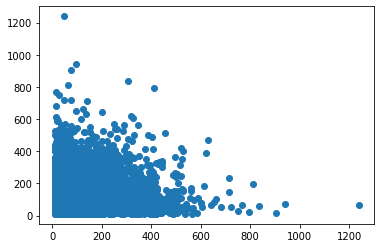

In [15]:
x, y = createTupel(durations)
plt.scatter(x,y)
plt.show()

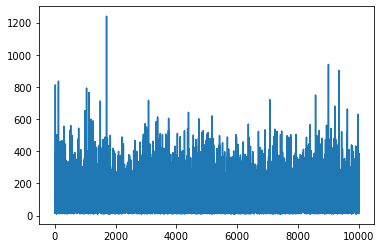

In [16]:
plt.plot(durations)
plt.show()

The data points are scattered throughout the first quarter. This indicates that the data is independent. The data sems to be identical distributed as well. We assume that the data is IID.

#### Step 2: Identify A Family Of Distributions

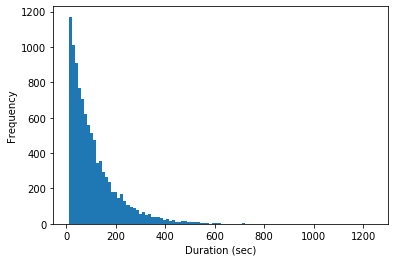

In [17]:
c = plt.hist(durations,k)
plt.xlabel('Duration (sec)')
plt.ylabel('Frequency')
plt.show()

In [18]:
print("Minimum: {}".format(min(durations)))

Minimum: 10.003951603252272


From the histogram we notice that there are no calls close to 0. The minimal time for a call is 10 sec. To fit a distribution to the data we assume that **a call lasts at least 10 sec** and that the remaining time has an exponential distribution.

#### Step 3: Estimation of the mean for the exponential distribution

In [19]:
remainingTime=[x-10 for x in durations]

In [20]:
meanCallDuration = sum(remainingTime)/len(remainingTime)
print("Expo({})".format(meanCallDuration))

Expo(99.83590073874737)


#### Step 4: Goodness-of-fit test of selected distribution
We use the chi-square test to test the hypothesis that these call interarrival times are exponentially distributed.

In [21]:
expIntervall=calExpInterall(meanCallDuration,k)
chiSquare(expIntervall,remainingTime,k)

95.91999999999999

So the test statistic is X2=95.9. The degree of freedom of the chi-square distribution **98**. We set our level of significance: **a=0.01**, the critical value is **134.642**. Since X2<134.642 the **hypothesis can be accepted**. Thus the hypothesised exponential distribution does fit the data well.

### III) Velocity Distribution
#### Step 1: Investigate Data Collection

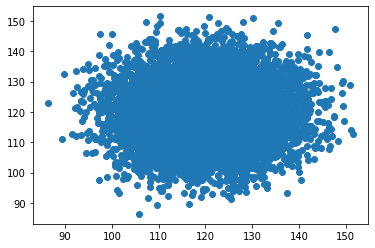

In [22]:
x, y = createTupel(velocities)
plt.scatter(x,y)
plt.show()

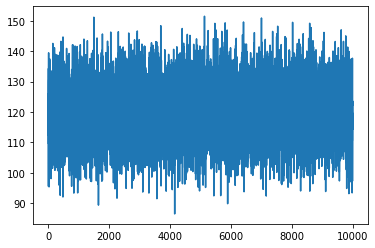

In [23]:
plt.plot(velocities)
plt.show()

By looking at the scatter plot and the plot of the data we see that most of the data is around 120. We assume that the data is IID.

#### Step 2: Identify A Family Of Distributions

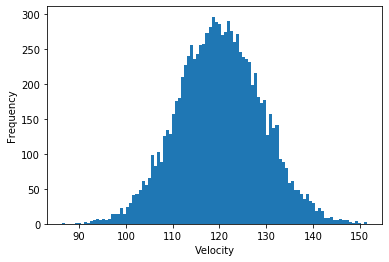

In [24]:
plt.hist(velocities,k)
plt.xlabel('Velocity')
plt.ylabel('Frequency')
plt.show()

We hypothesize the data has a normal distribution.

#### Step 3: Estimation of the parameters of a normal distribution

In [25]:
meanVelocity =np.mean(velocities)
stdVelocity=np.std(velocities)
print("N({}, {})".format(meanVelocity,stdVelocity**2))

N(120.07209801685764, 81.33527102508032)


#### Step 4: Goodness-of-fit test of selected distribution¶

In [26]:
def calNormInterall(mean,std,k):
    classIntervall = [0]
    for i in range(1,k):
        ai=norm.ppf(i/k,mean,std)
        classIntervall.append(ai)
    return classIntervall

In [27]:
normIntervall=calNormInterall(meanVelocity,stdVelocity,k)
chiSquare(normIntervall,velocities,k)

96.44

So the test statistic is X2=96.44. The degree of freedom of the chi-square distribution is k-s-1. For a normal distribution s=2. So the **degree of freedom is 97**. We set our **level of significants at a=0.01**, the critical value is **132.309**. Since X2<132.309 the **hypothesis can be accepted**. Thus the hypothesised normal distribution does fit the data well.

### IV) Base Station Distribution
#### Step 1: Investigate Data Collection
We know that we have 20 diffrent stations and that calls are handovered to the next cell left or right. 

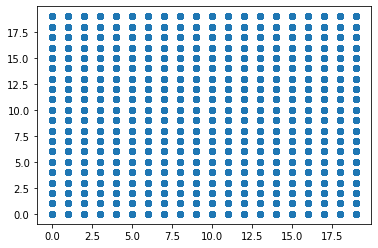

In [28]:
x, y = createTupel(baseStations)
plt.scatter(x,y)
plt.show()

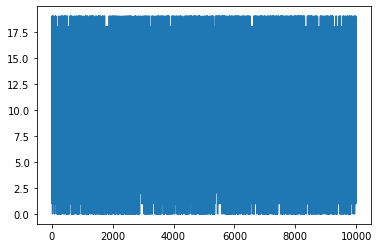

In [29]:
plt.plot(baseStations)
plt.show()

By looking at the scatter plot and the plot of the data we see already that the data has a normal distribution. We assume that the data is IID.
#### Step 2: Identify A Family Of Distributions

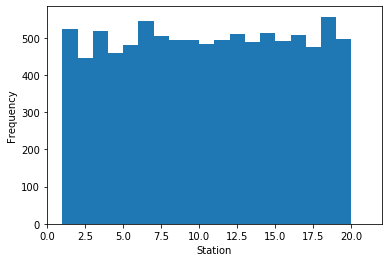

In [30]:
plt.hist(baseStations,20,[1,21])
plt.xlabel('Station')
plt.ylabel('Frequency')
plt.show()

We hypothesize the data has an uniform distribution U(1,20). We use the chi-square test to test the hypothesis. Since we only have 20 stations it is clear that k=20.

#### Step 3: Goodness-of-fit test of selected distribution

In [31]:
uniformIntervall=[x for x in range(20)]
chiSquare(uniformIntervall,baseStations,20)

25.656

So the test statistic is X2=25.656. The degree of freedom of the chi-square distribution is k-s-1. For a uniform distribution s=1. So the degree of freedom is **18**. We set our level of significants at **a=0.01**, the critical value is **34.805**. Since X2<34.805 the **hypothesis can be accepted**. Thus the hypothesised normal distribution U(1,20) does fit the data well.

## Warm up periode of simulation

To determine the lenght of the warm up periode of the simulation, we want to find out the average number of new calls in a short time periode from the meassured data.

Mean: 100.0


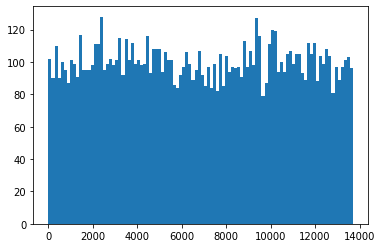

In [32]:
a=plt.hist(initationTimes,100)
print("Mean: {}".format(np.mean(a[0])))

We seperate the initation times of the calls in k=100 buckets. Since the last call initation time is at second 13697, the intervalls have a lenght of about 137 seconds. When we now calculate the mean amount of calls in one bucket we get 100. In avergae there are about 100 initation calls in 137 sec. 

**For our simulation the warm up periode will end, when we reach an interval i * 137 sec where in its time periode appear more than 100 calls.**

In [33]:
def CheckWarmUp(call):
    global initiatedCalls
    global warmUp
    
    if warmUp:
        for e in initiatedCalls: #check if there is already an intervall with 100 calls
            if e>=100:
                warmUp=False
                report.write("Time: " + str(currentTime) + " Warm Up periode is over" + "\n")
    
    i = int(call.time/137) #put call in intervall of lenght 137
    
    while i >= len(initiatedCalls): #make a new intervall
        initiatedCalls.append(0)
    initiatedCalls[i]+=1

## Events:
There are 3 types of Events that are handled by the simulator:

Call initiation [time, speed, station, position, duration, direction]

Call termination [time, station]

Call handover [time, speed, station, duration, direction]

In [34]:
class Event:
    def __gt__(self, other):
        return self.time > other.time

class InitiationEvent(Event):
    def __init__(self,time,speed,station,position,duration,direction):
        self.time = time
        self.speed = speed
        self.station = station
        self.position = position
        self.duration = duration
        self.direction = direction
        
class TerminationEvent(Event):
    def __init__(self,time,station):
        self.time = time
        self.station = station
        
class HandoverEvent(Event):
    def __init__(self,time,speed,station,duration,direction):
        self.time = time
        self.speed = speed
        self.station = station
        self.duration = duration
        self.direction = direction

## Code for generation random calls

Assumptions:

(a) The traffic volumes in the two directions are the same.  This means the two directions of 
cars travelling along the highway have equal probabilities. 

(b) A car maintains the same speed during a call.   

(c) The position of the car initiating a call in a cell is uniformly distributed along the section 
of the highway covered by the base station. 

In [35]:
def genRandomCall():
    callInterarrivalTime=np.random.exponential(meanCallInterarrival)
    initiationTime=currentTime+callInterarrivalTime
    
    duration=10.0+np.random.exponential(meanCallDuration)
    
    speed=np.random.normal(meanVelocity,stdVelocity)
    
    baseStation=random.randint(1,20)-1 #returns integer from the discret uniform distribution
    #we use indexing from 0 insted from 1
        
    position=random.uniform(0,2)
    direction=int((-1)**random.randint(-1,0)) #-1 for going west, 1 for going east
        
    callInitiationEvent=InitiationEvent(initiationTime,speed,baseStation,position,duration,direction)
    heappush(eventHeap, callInitiationEvent)

## Event Handling Functions

In [36]:
def initiationEventHandler(event):
    if stations[event.station]<channelsForNewCalls:
        stations[event.station]+=1
        
        report.write("Event Time: " + str(event.time) + " Call started in station " + str(event.station+1)+"\n")
        
        computeNextEvent(event)
        
    else:
        report.write("Event Time: " + str(event.time) + " Call blocked in station " + str(event.station+1)+"\n")
        
        if not warmUp: #If the warm up periode is over, the blocked calls are counted
            global callsBlocked
            callsBlocked+=1
        
    report.write(str(stations)+"\n")
    
    CheckWarmUp(event)
    
    if not warmUp:
        global callsTotal
        callsTotal+=1
        
    genRandomCall()

In [37]:
def handoverEventHandler(event):
    stations[event.station-event.direction]-=1
    if stations[event.station]<10:
        stations[event.station]+=1
        
        report.write("Event Time: " + str(event.time) + " Call hadover to station " + str(event.station+1)+"\n")
        
        computeNextEvent(event)
    else:
        report.write("Event Time: " + str(event.time) + " Call dropped at station " + str(event.station+1)+"\n")
        
        if not warmUp: #If the warm up periode is over, the dropped calls are counted
            global callsDropped
            callsDropped+=1
            
    report.write(str(stations)+"\n")

In [38]:
def terminationEventHandler(event):
    stations[event.station]-=1
    report.write("Event Time: " + str(event.time) + " Call terminated in station " + str(event.station+1)+"\n")
    report.write(str(stations)+"\n")

In this function the math for computing the time of the next event happens and the new event is created and pushed onto the heap

In [39]:
def computeNextEvent(event):
    if isinstance(event,HandoverEvent):
        distnanceToNextCell=2
    else:
        #the position relative to the station is computed
        if event.direction == -1:
            distnanceToNextCell=event.position
        else:
            distnanceToNextCell=2-event.position
        
    timeToNextCell=(distnanceToNextCell/event.speed)*60*60 #time is meassured in sec
    nextStation=event.station+event.direction
    time=currentTime+timeToNextCell
    
    if timeToNextCell >= event.duration: #call ends in this cell
        teminationTime=currentTime+event.duration
        callTerminationEvent = TerminationEvent(teminationTime,event.station)
        heappush(eventHeap,callTerminationEvent)
        
    elif nextStation<0 or nextStation > 19: #car leaves the highway
        callTerminationEvent = TerminationEvent(time,event.station)
        heappush(eventHeap,callTerminationEvent)
        
    else: #call handover
        speed = event.speed
        duration = event.duration-timeToNextCell
        direction = event.direction
        callHandoverEvent = HandoverEvent(time,speed,nextStation,duration,direction)
        heappush(eventHeap,callHandoverEvent)

## Main simulation function

In [40]:
def simulate(simulationTime):
    global currentTime
    global warmUpTime
    genRandomCall()
    
    while (len(eventHeap)>0 and simulationTime+warmUpTime>currentTime):
        event = heappop(eventHeap)
        currentTime=event.time
        
        if isinstance(event,InitiationEvent):
            initiationEventHandler(event)
        elif isinstance(event,TerminationEvent):
            terminationEventHandler(event)
        else:   
            handoverEventHandler(event)
    report.close()

## Running the simulation

In [41]:
def refresh(): #Used to define and clear all simulation related variables for one run
    global eventHeap
    global stations
    global currentTime
    global callsDropped
    global callsBlocked
    global callsTotal
    global report
    global warmUp
    global initiatedCalls
    global warmUpTime
    
    eventHeap = [] #We use a heap to shedule the order of the events
    stations = [0]*20 #Each element in the list represents one station (index 0-19) with 0-10 free channels
    currentTime = 0.0
    callsDropped=0 #Calls droped after warm up
    callsBlocked=0 #Calls blocked after warm up
    callsTotal=0 #Total calls after warm up
    report = open("report.txt", "w") #file for the report
    warmUp=True
    initiatedCalls=[] #intervall of 137 to count calls
    warmUpTime = 0 #The time is unknown so far and will be determined by the WarmUp Methode

In [42]:
def doNruns(n):

    allDroppedCalls=[]
    allBlockedCalls=[]

    while n>0:
        refresh()
        simulate(simulationTime)
        allDroppedCalls.append((callsDropped/callsTotal)*100)
        allBlockedCalls.append((callsBlocked/callsTotal)*100)
        n-=1
    return allDroppedCalls, allBlockedCalls

### FCA 10 - No reservation

+ Simulation Time: 24 hours plus warm-up time
+ 10 runs

In [43]:
#Max open channels for new calls, depends on how many channels are reserved for Handover
channelsForNewCalls=10
simulationTime=60*60*24
n=10
ToalPercentDroppedCalls10,ToalPercentBlockedCalls10 = doNruns(n)
TotalPercentBlockedAndDropped10 = np.array(ToalPercentDroppedCalls10)+np.array(ToalPercentBlockedCalls10)

### FCA 9 - One channel reservated for Handover

+ Simulation Time: 24 hours plus warm-up time
+ 10 runs

In [44]:
#Max open channels for new calls, depends on how many channels are reserved for Handover
channelsForNewCalls=9
simulationTime=60*60*24
n=10
ToalPercentDroppedCalls9,ToalPercentBlockedCalls9 = doNruns(n)
TotalPercentBlockedAndDropped9 = np.array(ToalPercentDroppedCalls9)+np.array(ToalPercentBlockedCalls9)

### FCA 8 - Two channel reservated for Handover

+ Simulation Time: 24 hours plus warm-up time
+ 10 runs

In [45]:
#Max open channels for new calls, depends on how many channels are reserved for Handover
channelsForNewCalls=8
simulationTime=60*60*24
n=10
ToalPercentDroppedCalls8,ToalPercentBlockedCalls8 = doNruns(n)
TotalPercentBlockedAndDropped8 = np.array(ToalPercentDroppedCalls8)+np.array(ToalPercentBlockedCalls8)

## Output Analysis

In [46]:
def calcS2(array):
    xj=np.array(array)
    s2=np.sum((xj-np.mean(xj))**2)/(len(xj)-1)
    return s2

def calcConfidenceInterval(array,t):
    mean=np.mean(array)
    s2=calcS2(array)
    l=t*(np.sqrt(s2)/np.sqrt(n))
    return [mean-l,mean+l], mean

### Confidence interval 

We calculate the 95% confidence interval with a statistical significants of a = 0.05 to give recommendations for the FCA scheme. We expect that with a properbility of 95%, our interval captures the true population parameter.

In [47]:
t=2.262
ConfidenceIntervalDropped10, meanDropped10=calcConfidenceInterval(ToalPercentDroppedCalls10,t)
ConfidenceIntervalBlocked10, meanBlocked10=calcConfidenceInterval(ToalPercentBlockedCalls10,t)
ConfidenceIntervallTotalIncidents10, meanTotal10=calcConfidenceInterval(TotalPercentBlockedAndDropped10,t)

ConfidenceIntervalDropped9, meanDropped9=calcConfidenceInterval(ToalPercentDroppedCalls9,t)
ConfidenceIntervalBlocked9, meanBlocked9=calcConfidenceInterval(ToalPercentBlockedCalls9,t)
ConfidenceIntervallTotalIncidents9, meanTotal9=calcConfidenceInterval(TotalPercentBlockedAndDropped9,t)

ConfidenceIntervalDropped8, meanDropped8=calcConfidenceInterval(ToalPercentDroppedCalls8,t)
ConfidenceIntervalBlocked8, meanBlocked8=calcConfidenceInterval(ToalPercentBlockedCalls8,t)
ConfidenceIntervallTotalIncidents8, meanTotal8=calcConfidenceInterval(TotalPercentBlockedAndDropped8,t)

#### FCA10 

In [48]:
print("Confidence Interval for dropped calls: "+str(ConfidenceIntervalDropped10))
print("Confidence Interval for blocked calls: "+str(ConfidenceIntervalBlocked10))
print("Confidence Interval for dropped and blocked calls: "+str(ConfidenceIntervallTotalIncidents10))

Confidence Interval for dropped calls: [0.5184293047322447, 0.5935820862361804]
Confidence Interval for blocked calls: [0.30668651398447, 0.34485324909635884]
Confidence Interval for dropped and blocked calls: [0.8274567004499656, 0.9360944535992881]


#### FCA9

In [49]:
print("Confidence Interval for dropped calls: "+str(ConfidenceIntervalDropped9))
print("Confidence Interval for blocked calls: "+str(ConfidenceIntervalBlocked9))
print("Confidence Interval for dropped and blocked calls: "+str(ConfidenceIntervallTotalIncidents9))

Confidence Interval for dropped calls: [0.31539170859027493, 0.3608868143927652]
Confidence Interval for blocked calls: [1.063944014694628, 1.126980532536468]
Confidence Interval for dropped and blocked calls: [1.3982658333165858, 1.4689372368975504]


#### FCA8

In [50]:
print("Confidence Interval for dropped calls: "+str(ConfidenceIntervalDropped8))
print("Confidence Interval for blocked calls: "+str(ConfidenceIntervalBlocked8))
print("Confidence Interval for dropped and blocked calls: "+str(ConfidenceIntervallTotalIncidents8))

Confidence Interval for dropped calls: [0.16469675119825472, 0.20873496813455522]
Confidence Interval for blocked calls: [2.629827654213221, 2.7775649395672515]
Confidence Interval for dropped and blocked calls: [2.811677962435635, 2.9691463506776485]


## Summary of simulation conclusions and recommendations

+ FCA10 and FCA9 both fullfill the service requirements
+ FCA 8 does not fullfill the requirements, since Blocked Calls > 2%

### We now have to compare FCA10 against FCA9
#### Paired-t confidence interval
We calculate the 95% confidence interval with a statistical significants of a = 0.05 to give recommendations for the FCA scheme. We expect that with a properbility of 95%, our interval captures the true population parameter. With approximately 95% confidence, we can say which strategy is better.

In [51]:
t=2.262
DiffrenceDropped = np.array(ToalPercentDroppedCalls10)-np.array(ToalPercentDroppedCalls9)
ConfidenceIntervalDropped10_9, meanDropped10_9 = calcConfidenceInterval(DiffrenceDropped,t)

DiffrenceBlocked = np.array(ToalPercentBlockedCalls10)-np.array(ToalPercentBlockedCalls9)
ConfidenceIntervalBlocked10_9, meanBlocked10_9 = calcConfidenceInterval(DiffrenceBlocked,t)

DiffrenceTotal = np.array(ConfidenceIntervallTotalIncidents10)-np.array(ConfidenceIntervallTotalIncidents9)
ConfidenceIntervalTotal10_9, meanTotal10_9 = calcConfidenceInterval(DiffrenceTotal,t)

In [52]:
print("The amount of dropped calls decreases by {}% - {}% with FCA9)".format(ConfidenceIntervalDropped10_9[0],
                                                                             ConfidenceIntervalDropped10_9[1]))
print("the amount of blocked calls increases by {}% - {}% with FCA9)".format(abs(ConfidenceIntervalBlocked10_9[0]),
                                                                            abs(ConfidenceIntervalBlocked10_9[1])))
print("In total there are between {}% - {}% more calls blocked and dropped with FCA9".format(abs(ConfidenceIntervalTotal10_9[0]),
                                                                                            abs(ConfidenceIntervalTotal10_9[1])))

The amount of dropped calls decreases by 0.17487317549525777% - 0.26085969249012725% with FCA9)
the amount of blocked calls increases by 0.8022793572366836% - 0.7371054269135834% with FCA9)
In total there are between 0.571029283649415% - 0.5326226325154676% more calls blocked and dropped with FCA9


##### The company has to decide between FCA10 and FCA9 depending on their policy
+ **If we care more about dropped calls and can accept more blocked calls, we can use FCA9**
+ **If we want to increase the overall performance of the system (less blocked and dropped calls) we should stay with FCA10**